# EMアルゴリズム

点推定を数値的に行う手法。

参考

- [【徹底解説】EM アルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)
- [EM アルゴリズムとともだちになろう | ドクセル](https://www.docswell.com/s/mutopsy/K18DP5-2022-08-16-163818)


In [20]:
import random
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


---

## 潜在変数

観測データの裏に潜む、データをよく表した**観測できない**変数。

観測データの分布が複雑な時は、潜在変数を導入することで計算が簡単になる場合が多い。

潜在変数の導入とは、観測されたデータ$X=\{x^{(1)}, x^{(2)}, \cdots, x^{(N)}\}$の裏に潜在変数$Z=\{z^{(1)}, z^{(2)}, \cdots, z^{(N)}\}$が存在すると仮定し、それをモデル化すること。$x$に影響を与える何らかの確率変数を考え、それがどのように観測データに作用するかをモデル化するということ。

潜在変数の導入を数学的に表現すると、それは観測データと潜在変数の同時分布を定めることになる。

$$
p(x,z) = p(x|z)p(z)
$$

潜在変数の分布$p(z)$と、それがデータ$x$にどう作用するかを表す条件付き分布$p(x|z)$を定めている。ベイズ的に言うなら事前分布と尤度関数。

潜在変数を導入し、尤度を以下のように周辺化して表す。

$$
\begin{align}

p(x;\theta)
    &= \sum_z p(x,z;\theta) \\
    &= \sum_z p(x|z;\theta)p(z;\theta)

\end{align}
$$


---

## EMアルゴリズム

EMアルゴリズムの計算方法を見ていく。

まず対数尤度関数を考える。

$$
\begin{align}
    \log p(X;\theta)
        &= \log \prod_{i=1}^n p(x^{(i)};\theta) \\
        &= \sum_{i=1}^n \log p(x^{(i)};\theta) \\
\end{align}
$$

尤度$p(x^{(i)};\theta)$が複雑で、このまま進めても解が求められない場合を考えていく。

ここで潜在変数を導入する。

$$
p(X;\theta) = \sum_Z p(X,Z;\theta)
$$


では、この下で対数尤度を見ていく。

$$
\begin{align}
\log p(X;\theta)
    &= \log \sum_Z p(X,Z;\theta) \\
    &= \log \sum_Z q(Z) \frac{p(X,Z;\theta)}{q(Z)} \\
    &\ge \sum_Z q(Z) \log \frac{p(X,Z;\theta)}{q(Z)} \\
    &= \mathcal{L}(q(Z),\theta)
\end{align}
$$

途中の不等式は**イェンゼンの不等式**というもの。$q(Z)$はイェンゼンの不等式を使うために適当に持ち出したなんらかの確率分布。現時点では明確になっていない。  

最後に出てきた式は下界と呼び、$\mathcal{L}(q(Z),\theta)$と置いた。エビデンス（対数尤度）の下界ということで、ELBO（Evidence lower bound）とも呼ぶ。変分ベイズでも出てくるので、変分下界（Variational Lower Bound）とも呼ぶ。

ここで、対数尤度関数と下限の差を求めると

$$
\begin{align}

& \log p(X; \theta) - \mathcal{L}(q(Z), \theta) \\

&\quad = \log p(X; \theta) - \sum_Z q(Z) \log \frac{p(X, Z; \theta)}{q(Z)} \\

&\quad = \sum_Z q(Z)\log p(X; \theta) - \sum_Z q(Z) \log \frac{p(X| Z; \theta)p(Z; \theta)}{q(Z)} \\

&\quad = \sum_Z q(Z) \Big( \log p(X; \theta) - \log p(X| Z; \theta) - \log p(Z; \theta) + \log q(Z) \Big) \\

&\quad = \sum_Z q(Z) \Big( -\log \frac{p(X| Z; \theta)p(Z; \theta)}{p(X; \theta)} + \log q(Z) \Big) \\

&\quad = \sum_Z q(Z) \Big( -\log p(Z| X; \theta) + \log q(Z) \Big) \\

&\quad = \sum_Z q(Z) \Big( \log \frac{q(Z)}{p(Z| X; \theta)} \Big) \\

&\quad = D_{KL}[q(Z) || p(Z| X; \theta)] 

\end{align}
$$

$q(Z)$と$p(Z|X,\theta)$の KL ダイバージェンスになる。KLダイバージェンスは二つの確率分布の近さを表す指標として知られる。

これを以下のようにまとめる。 

$$
\begin{align}

\log p(X; \theta) = \mathcal{L}(q(Z), \theta) + D_{KL}[q(Z) || p(Z| X; \theta)]

\end{align}
$$

対数尤度をKLダイバージェンスと下界の和で表すことが出来た。

我々はこれを最大化したい。ここで思いつくのは、下界とKLダイバージェンスを別々に最大化する方法である。そうすれば対数尤度も大きくなりそう。しかし、このやり方は上手くいかない。

真っ先に思いつくのは、下限と KL ダイバージェンスを別々に最大化する方法である。そうすれば対数尤度も大きくなりそう。しかし、このやり方は上手くいかない。なぜかな。

まず、我々が自由に操作できる変数は以下の二つである。

- $\theta$
- $q(Z)$

この二つの変数を対数尤度が最大になるように設定したい訳だが、実は対数尤度は$q(Z)$に依存しない。したがって、$q(Z)$をいじった時に変わるものは対数尤度ではなく、下限と KL ダイバージェンスの比率である。どちらかを大きくする$q(Z)$は、もう一方を小さくする$q(Z)$となる。


ではどうすべきか。正解は以下。

1. $\theta$を初期化する。
2. $\theta$を固定し、KL ダイバージェンスを最小化する。
3. $q(Z)$を固定し、下限を最大化する。
4. 2, 3 を繰り返す。


まずは$\theta$の初期化だがこれは何でもよい。とりあえず$\theta^{\text{old}}$と表記しておく。

次に、その$\theta^{\text{old}}$の下でKLダイバージェンスを最小化する。つまり$D_{KL}[q(Z) || p(Z| X; \theta^{\text{old}})]=0$となる$q(Z)$を求める。 ここで、KLダイバージェンスは二つの確率分布が完全に一致する際に唯一の0をとる。ということで、$q(Z) = p(Z| X; \theta^{\text{old}})$とする。

では今度はその$q(Z)$を固定して下限を最大化する。つまり以下を行う。

$$
\begin{align}

\theta^{\text{new}} = \argmax_\theta \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta)

\end{align}
$$

ここで下限を少し整理する。

$$
\begin{align}

\mathcal L (p(Z| X; \theta^{\text{old}}),\theta)

&= \sum_Z p(Z| X; \theta^{\text{old}}) \log \frac{p(X, Z; \theta)}{p(Z| X; \theta^{\text{old}})} \\

&= \sum_Z p(Z|X;\theta^{old}) \log p(X, Z; \theta) + \mathrm{const} \\

&= \mathbb E_{p(Z| X; \theta^{\text{old}})} \big[ \log p(X, Z; \theta) \big] + \mathrm{const} \\

&= \mathcal Q (\theta| \theta^{\text{old}}) + \mathrm{const}

\end{align}
$$

事後分布に関する同時分布の対数尤度の期待値になった。これは$\mathcal Q(\theta, \theta_{\text{old}})$と表しておく。この期待値を最大にする$\theta$を求め、それを新たな$\theta$とする。この期待値はsum-logの形になっており、解析的に解きやすい。

\begin{align}

\theta^{\text{new}} = \argmax_{\theta} \mathcal Q(\theta, \theta^{\text{old}})

\end{align}


そして$\theta^{\text{old}} := \theta^{\text{new}}$として、同じように期待値を最大化する。これを繰り返すことで、対数尤度を大きくすることができる。

ということで、EMアルゴリズムの流れは以下。

1. 潜在変数の導入
2. パラメータ$\theta^{\text{old}}$の初期化
3. 同時分布の期待値の最大化:
    - $\theta^{\text{new}} \larr \argmax_\theta \mathcal Q(\theta|\theta^{\text{old}})$
    - $\theta^{\text{old}} \larr \theta^{\text{new}}$
4. 3を繰り返す

期待値（*Expected value*）の最大化（*Maximization*）を繰り返すため、EM アルゴリズムと呼ばれる。また、数学的には期待値を求めるステップと最大化のステップに分けられ、それぞれEステップ・Mステップと呼ばれたりする。

### 対数尤度が単調増加することの証明

以下を示す。

$$
\begin{align}

\log p(X; \theta^{\text{new}}) \geq \log p(X; \theta^{\text{old}})

\end{align}
$$

$q(Z) = p(Z| X; \theta)$であるとき、対数尤度と下界は一致する。よって

$$
\begin{align}

\log p(X; \theta^{\text{old}}) = \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{old}})

\end{align}
$$

ここで、

$$
\begin{align}

\theta^{\text{new}} = \argmax_\theta \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta)

\end{align}
$$

より、

$$
\begin{align}

\mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{new}}) \geq \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{old}})

\end{align}
$$

が成り立つ。

が成り立つ。また、任意の$q(Z)$で

$$
\begin{align}

\log p(X; \theta) \geq \mathcal{L}(p(Z), \theta)

\end{align}
$$

が成り立つので、

$$
\begin{align}

\log p(X; \theta^{\text{new}}) \geq \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{new}})

\end{align}
$$

が成り立つ。よって

$$
\begin{align}

\log p(X; \theta^{\text{new}}) 

&\geq \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{new}}) \\

&\geq \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{old}}) \\

&= \log p(X; \theta^{\text{old}})

\end{align}
$$

が成り立つ。証明終わり。

なお、ここで示したのは対数尤度が単調増加することで、パラメータが最適解に収束することではない。いわゆる局所解に陥るといった状況はEMアルゴリズムでも起こり得るので、初期値依存の手法ではある。


---

## 混合ガウス分布

GMM: *Gaussian Mixture Model*

割合だけでなく、各ガウス分布の平均と分散も推定する。また多変量ガウス分布に拡張する。

例えば、以下のようなサンプルが得られたとする。

In [ ]:
class GaussianMixture:
    def __init__(self, n_components, max_iter=100):
        self.n_components = n_components
        self.max_iter = max_iter
        self.mu = None
        self.sigma = None
        self.pi = None

    def fit(self, X):
        N, d = X.shape
        self._init_params(d)

        for _ in range(self.max_iter):
            gamma = self._get_gamma(X)
            Nk = gamma.sum(axis=1)

            mu = gamma @ X / Nk.reshape(-1, 1)
            sigma = np.array([
                ((X - muk).T * gammak) @ (X - muk)
                for muk, gammak in zip(self.mu, gamma)
            ]) / Nk.reshape(-1, 1, 1)

            # sigma = []
            # for k in range(self.n_components):
            #     g = gamma[k]
            #     m = self.mu[k]
            #     sigmak = (g.reshape(-1, 1, 1) * np.array([(x - m).reshape(-1, 1) @ (x - m).reshape(1, -1) for x in X])).sum(0)
                
            #     sigma.append(sigmak)

            # print(Nk.shape)
            self.mu = mu
            self.sigma = np.array(sigma)# / Nk.reshape(-1, 1, 1)
            self.pi = Nk / N
            # print(self.mu.shape, self.sigma.shape, self.pi.shape)

    def predict(self, X):
        gamma = self._get_gamma(X)
        c = gamma.argmax(axis=0)
        return c

    def _init_params(self, d):
        self.mu = np.random.randn(self.n_components, d)
        self.sigma = np.array([np.eye(d) for _ in range(self.n_components)])
        self.pi = np.random.rand(self.n_components)
        self.pi /= self.pi.max()

    def _get_gamma(self, X):
        joint_probs = []
        for mu, sigma, pi in zip(self.mu, self.sigma, self.pi):
            likelihood = sp.stats.multivariate_normal.pdf(X, mean=mu, cov=sigma)
            joint_prob = pi * likelihood
            joint_probs.append(joint_prob)
        joint_probs = np.array(joint_probs)
        gamma = joint_probs / joint_probs.sum(axis=0) # (K, N)
        return gamma

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
from sklearn.datasets import make_blobs

In [3]:
N = 500
d = 2
K = 3

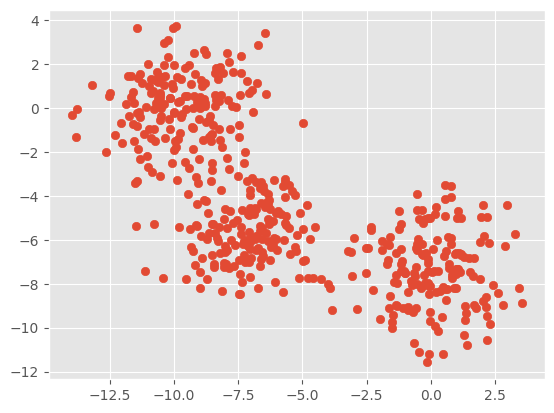

In [4]:
X, y = make_blobs(
    n_samples=N,
    n_features=d,
    centers=K,
    cluster_std=1.5,
    random_state=9,
)
plt.scatter(X[:, 0], X[:, 1]);

In [112]:
class GaussianMixture:
    def __init__(self, n_components, max_iter=100):
        self.n_components = n_components
        self.max_iter = max_iter
        self.mu = None
        self.sigma = None
        self.pi = None

    def fit(self, X):
        N, d = X.shape
        self._init_params(d)

        for _ in range(self.max_iter):
            gamma = self._posterior_prod(X)
            Nk = gamma.sum(axis=1)

            self.mu = gamma @ X / Nk.reshape(-1, 1)

            for i in range(self.n_components):
                mu = self.mu[i]
                self.sigma[i] = gamma[i] * (X - mu).T @ (X - mu) / Nk[i]

            self.pi = Nk / N

    def predict(self, X):
        gamma = self._posterior_prod(X)
        c = gamma.argmax(axis=0)
        return c

    def _init_params(self, d):
        self.mu = np.random.randn(self.n_components, d) # (K, d)
        self.sigma = np.tile(np.eye(d), (self.n_components, 1, 1)) # (K, d, d)
        self.pi = np.ones(self.n_components) / self.n_components # (K,)

    def _posterior_prod(self, X):
        joint_probs = []
        for mu, sigma, pi in zip(self.mu, self.sigma, self.pi):
            norm = sp.stats.multivariate_normal(mean=mu, cov=sigma)
            likelihood = norm.pdf(X)
            joint_prob = pi * likelihood
            joint_probs.append(joint_prob)
        joint_probs = np.array(joint_probs)
        gamma = joint_probs / joint_probs.sum(axis=0) # (K, N)
        return gamma

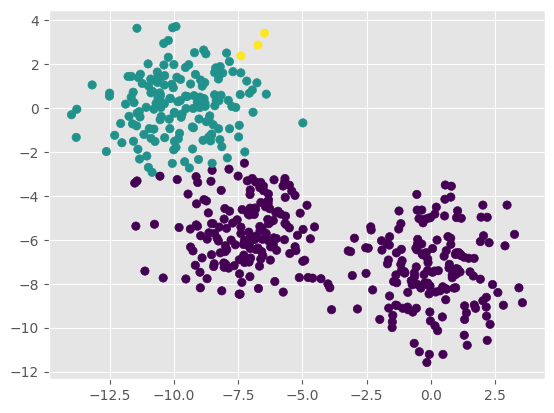

In [131]:
gmm = GaussianMixture(n_components=K)
gmm.fit(X)
clusters = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters);

In [98]:
from sklearn.mixture import GaussianMixture as CorrectGMM

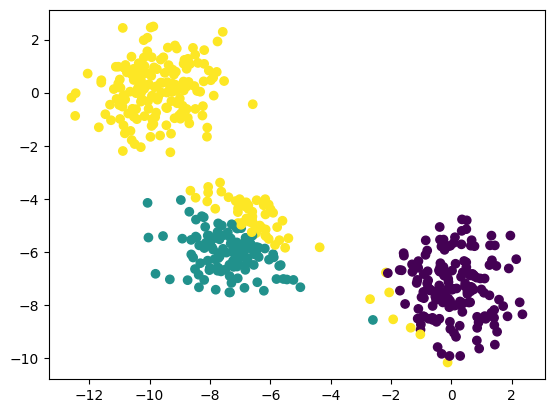

In [144]:
gmm = CorrectGMM(K, init_params="random")
gmm.fit(X)
clusters = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters);

ここから、各ガウス分布の平均、共分散行列、混合比率を推定する。クラスタ数（ガウス分布の数）だけはこちらで仮定する必要がある。

まず、モデル化していく。

$$
p(\boldsymbol x;\theta) = \sum_{k=1}^K \pi_k \mathcal N_k(\boldsymbol x)
$$

$K$はクラスタ数。

$\mathcal N_k(\boldsymbol x)$は$k$番目のガウス分布で、それぞれがパラメータとして平均$\boldsymbol\mu_k$と共分散行列$\Sigma_k$を持つ。

$$
\mathcal N_k(\boldsymbol x) = \mathcal N(\boldsymbol x;\boldsymbol\mu_k, \Sigma_k)
$$

$\pi_k$は$k$番目のガウス分布の混合比率で、これもパラメータの一つ。比率$\pi_k$の総和は1でないといけない。

$$
\sum_{k=1}^K \pi_k = 1
$$

先ほど同様、同時分布を定義し、潜在変数を導入する。

$$
\begin{align}

p(x,z;\theta)
    &= p(x|z;\theta)p(z;\theta) \\
    &= \mathcal N_{z}(x) \pi_z \\

\end{align}
$$

期待値。

$$
\begin{align}

\mathcal Q(\theta, \theta_{old})
    &= \mathbb E_{p(Z|X;\theta_{old})} [ \, \log p(X, Z| \theta) \, ] \\
    &= \sum_i \mathbb E_{p(z^{(i)}| x^{(i)}; \theta_{old})} \left[ \, \log p(x^{(i)}, z^{(i)} | \theta) \, \right] \\
    &= \sum_i \mathbb E_{p(z^{(i)}| x^{(i)}; \theta_{old})} \left[ \, \log \mathcal N_{z^{(i)}}(x^{(i)}) + \log \pi_{z^{(i)}} \, \right] \\
    &= \sum_i \sum_k p(z_{(i)}=k| x^{(i)}; \theta_{old}) \left( \log \mathcal N_k(x^{(i)}) + \log \pi_k \right) \\
    &= \sum_i \sum_k r_k^{(i)} \left( \log \mathcal N_k(x^{(i)}) + \log \pi_k \right) \\
    &= \sum_i \sum_k r_k^{(i)} \left( -\frac{1}{2} \Big( d \log(2\pi) + \log |\Sigma| + (\boldsymbol x - \boldsymbol\mu)^T \Sigma^{-1} (\boldsymbol x - \boldsymbol\mu) \Big) + \log \pi_k \right) \\

\end{align}
$$

最後は

$$
\begin{align}

\log \mathcal N(\boldsymbol x; \boldsymbol\mu, \Sigma)
    &= \log \left( \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} \exp \left( -\frac{1}{2} (\boldsymbol x - \boldsymbol\mu)^T \Sigma (\boldsymbol x - \boldsymbol\mu) \right) \right) \\
    &= -\frac{1}{2} \log \Big( (2\pi)^d |\Sigma| \Big) -\frac{1}{2} (\boldsymbol x - \boldsymbol\mu)^T \Sigma^{-1} (\boldsymbol x - \boldsymbol\mu) \\
    &= -\frac{1}{2} \Big( d \log(2\pi) + \log |\Sigma| + (\boldsymbol x - \boldsymbol\mu)^T \Sigma^{-1} (\boldsymbol x - \boldsymbol\mu) \Big)

\end{align}
$$

各パラメータで微分していく。

$$
\begin{align}

\frac{\partial \mathcal Q}{\partial \boldsymbol\mu_k}
    &= \sum_i r_k^{(i)} \frac{1}{\pi_k} \\

\end{align}
$$